In [1]:
# %%
# =============================================================================
# SCRIPT 3.1 — EIT → PAP (SpatioTemporal) with CNN + BiLSTM
# Deterministic data loading, robust CSV I/O, full metrics, early stopping,
# best checkpointing, and per-patient evaluation & plotting
# =============================================================================

import os, random, time
from contextlib import nullcontext
from typing import List, Tuple, Dict, Optional

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# ------------------------------- Config / Device -----------------------------
DEBUG = True
SEED = 123
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE.upper()}" + (f" → {torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else ""))

# --- Determinism helpers ---
def set_deterministic(seed: int = 42):
    """
    Make Python, NumPy, and PyTorch behave as deterministically as possible.
    Notes:
      - cuDNN deterministic mode can slow down some ops but avoids nondeterminism.
      - Some GPU algorithms still have nondeterministic paths; we guard with try/except.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)
    # Needed by PyTorch to make certain cuBLAS calls deterministic
    os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":4096:8")

    # Seed all the usual suspects
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Force deterministic kernels in cuDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Extra guard (PyTorch >= 1.8) – some ops refuse deterministic paths and will error
    try:
        torch.use_deterministic_algorithms(True)
    except Exception:
        # Older versions or ops that don't support strict determinism
        pass

def make_generator(seed: int) -> torch.Generator:
    """Return a torch.Generator seeded for deterministic DataLoader shuffles."""
    g = torch.Generator()
    g.manual_seed(seed)
    return g

def make_worker_init_fn(base_seed: int):
    """
    Create a worker_init_fn that deterministically offsets seeds per worker.
    Ensures each worker's numpy/random/torch RNGs are reproducible.
    """
    def _fn(worker_id: int):
        s = base_seed + worker_id
        random.seed(s)
        np.random.seed(s % (2**32 - 1))
        torch.manual_seed(s)
    return _fn

set_deterministic(SEED)

# --------------------------- Normalization helpers ---------------------------
def standardize_signal(signal: np.ndarray) -> np.ndarray:
    """
    z-score a 1D signal (per patient/channel) using mean/std computed over that series.
    This keeps each channel roughly in [-3, 3] and removes offsets/gain differences.
    """
    scaler = StandardScaler()
    return scaler.fit_transform(signal.reshape(-1, 1)).flatten()

def make_trend(y: np.ndarray, win=81, poly=3) -> np.ndarray:
    """
    Smooth a 1D series with:
      1) small rolling-median (removes sharp spikes),
      2) Savitzky–Golay filter (preserves morphology while smoothing).
    Guardrails:
      - window must be odd and > poly; we auto-fix it if needed.
    """
    # Ensure Savitzky-Golay window is odd and > poly to avoid runtime errors
    win = int(win)
    if win % 2 == 0:
        win += 1
    if win <= poly:
        win = poly + 2 + (poly % 2 == 0)  # ensure > poly and odd

    # Robustify first with a tiny median to kill impulsive artifacts
    y_med = pd.Series(y).rolling(11, center=True, min_periods=1).median().to_numpy()
    # SG produces a smooth "trend-like" target that is easier to learn
    y_tr  = savgol_filter(y_med, window_length=win, polyorder=poly, mode="interp")
    return y_tr.astype(np.float32)

def _vector_to_grid(v: np.ndarray) -> np.ndarray:
    """
    Convert a 208-D EIT frame vector into a 13×16 2D grid.
    Raises if the vector doesn't have exactly 208 channels.
    """
    v = np.asarray(v)
    if v.shape[-1] != 208:
        raise ValueError(f"Expected 208 channels, got {v.shape[-1]}")
    return v.reshape(13, 16)

# ------------------------------ CSV I/O (robust) -----------------------------
def _read_csv_basic(path: str, **kwargs) -> pd.DataFrame:
    """Thin wrapper around pandas.read_csv to allow uniform patching."""
    return pd.read_csv(path, **kwargs)

def _sniff_delimiter(path: str) -> str:
    """
    Heuristically guess delimiter among [',', ';', '\\t'] using first couple KB.
    Falls back to comma if nothing stands out.
    """
    try:
        with open(path, "r", errors="ignore") as f:
            head = f.read(4096)
        commas = head.count(","); semis = head.count(";"); tabs = head.count("\t")
        if max(commas, semis, tabs) == 0: return ","
        return ";" if semis >= max(commas, tabs) else ("\t" if tabs > commas else ",")
    except Exception:
        return ","

def _to_numeric_best(s: pd.Series) -> np.ndarray:
    """
    Try parsing numeric as-is, and again after replacing ',' → '.'
    (handles locales that use decimal comma). Choose the variant with
    more finite values.
    """
    a = pd.to_numeric(s, errors="coerce")
    try:
        b = pd.to_numeric(s.astype(str).str.replace(",", ".", regex=False), errors="coerce")
    except Exception:
        b = a
    a_valid = int(np.isfinite(a).sum()); b_valid = int(np.isfinite(b).sum())
    best = b if b_valid > a_valid else a
    return best.to_numpy(dtype=np.float32)

def _read_pap_csv_robust(path: str) -> pd.DataFrame:
    """
    Robust PAP file read:
      1) Let pandas sniff the sep.
      2) Fallback to our own delimiter sniffing.
      3) Final fallback: read as strings (we'll coerce downstream).
    """
    try:
        df = _read_csv_basic(path, sep=None, engine="python")
        if df.shape[1] >= 1: return df
    except Exception: pass
    delim = _sniff_delimiter(path)
    try:
        df = _read_csv_basic(path, sep=delim)
        if df.shape[1] >= 1: return df
    except Exception: pass
    try:
        return _read_csv_basic(path, dtype=str, sep=None, engine="python")
    except Exception as e:
        raise RuntimeError(f"Failed to read PAP CSV: {path} → {e}")

def _read_voltage_csv_robust(path: str) -> pd.DataFrame:
    """
    Voltage CSVs are usually headerless numeric matrices.
    We try (header=None) first, then fallback to sep sniffing.
    """
    try:
        return _read_csv_basic(path, header=None)
    except Exception: pass
    try:
        return _read_csv_basic(path, sep=None, engine="python", header=None)
    except Exception: pass
    return _read_csv_basic(path)

# ------------------------------ PAP column pick ------------------------------
def _pick_pap_series(pap_df: pd.DataFrame, *, pid: str = "") -> np.ndarray:
    """
    Choose the PAP/perfusion column robustly:
      - Prefer known name patterns (case-insensitive).
      - Else, pick the column with highest numeric-valid ratio (≥0.2).
    """
    preferred = ["pap_on_voltage_apnea", "pap_on_eit", "pap", "perfusion", "pressure"]
    drop_like = {"time", "time_s", "t", "index", "unnamed: 0", "patientid", "id"}

    # 1) Named preference
    for col in pap_df.columns:
        name = str(col).lower()
        if any(k in name for k in preferred):
            s_num = _to_numeric_best(pap_df[col])
            if np.isfinite(s_num).sum() > 0:
                if DEBUG:
                    print(f"[INFO] {pid}: using PAP column '{col}'")
                return s_num

    # 2) Fallback: most numeric-looking column
    best_col, best_valid_ratio, best_series = None, -1.0, None
    for col in pap_df.columns:
        if str(col).lower() in drop_like: continue
        s_num = _to_numeric_best(pap_df[col])
        if s_num.size == 0: continue
        valid_ratio = np.isfinite(s_num).sum() / s_num.size
        if valid_ratio > best_valid_ratio:
            best_col, best_valid_ratio, best_series = col, valid_ratio, s_num

    if best_series is not None and best_valid_ratio >= 0.2:
        if DEBUG:
            print(f"[INFO] {pid}: fallback PAP column '{best_col}' (ratio={best_valid_ratio:.2f})")
        return best_series

    raise ValueError("No suitable numeric PAP column found.")

# ------------------------------ Pairing logic --------------------------------
def _canon_id_from_voltage(fname: str) -> str:
    """
    Map a voltage filename to its canonical patient ID by stripping suffixes.
    Example: 'TDL001_voltage_apnea.csv' → 'TDL001'
    """
    stem = os.path.splitext(os.path.basename(fname))[0]
    return stem.replace("_voltage_apnea", "")

def _canon_id_from_pap(fname: str) -> str:
    """Map a PAP filename to patient ID by stripping any of the known suffixes."""
    stem = os.path.splitext(os.path.basename(fname))[0]
    for suf in ["_pap_on_voltage_apnea","_pap_on_eit","_pap_upsampled","_pap","-pap","_perfusion","-perfusion"]:
        if stem.endswith(suf): return stem[: -len(suf)]
    return stem

def _pair_voltage_pap_files(voltage_folder: str, pap_folder: str) -> List[Tuple[str, str, str]]:
    """
    Find filename-matched (voltage, PAP) pairs across two folders.
    Returns: list of (patient_id, path_to_voltage_csv, path_to_pap_csv).
    """
    volt_map = { _canon_id_from_voltage(f): os.path.join(voltage_folder, f)
                 for f in os.listdir(voltage_folder) if f.lower().endswith(".csv") }
    pap_map  = { _canon_id_from_pap(f): os.path.join(pap_folder, f)
                 for f in os.listdir(pap_folder) if f.lower().endswith(".csv") }
    common = sorted(set(volt_map) & set(pap_map))
    pairs = [(pid, volt_map[pid], pap_map[pid]) for pid in common]

    # Log missing counterparts to help curate datasets
    missing_pap  = sorted(set(volt_map) - set(pap_map))
    missing_volt = sorted(set(pap_map)  - set(volt_map))
    if missing_pap:
        print(f"[WARN] {len(missing_pap)} voltage IDs lack PAP: {missing_pap[:8]}{' ...' if len(missing_pap)>8 else ''}")
    if missing_volt:
        print(f"[WARN] {len(missing_volt)} PAP IDs lack voltage: {missing_volt[:8]}{' ...' if len(missing_volt)>8 else ''}")
    print(f"Paired {len(pairs)} patients")
    return pairs

# ---------------------------- Patient processing -----------------------------
def process_single_patient(voltage_df: pd.DataFrame, pap_df: pd.DataFrame, *, pid: str = "") -> Dict[str, np.ndarray]:
    """
    Convert raw CSVs into aligned arrays and per-patient standardized matrices.
    Returns a dict with:
      - 'voltages': (T, 208) raw
      - 'pap'     : (T,)     raw
      - 'normalized_voltages': z-scored per channel (T, 208)
      - 'normalized_pap'     : z-scored (T,)
    """
    # 1) Voltage: keep only numeric columns; require ≥208 (the EIT grid)
    volt_num = voltage_df.select_dtypes(include=[np.number])
    if volt_num.shape[1] < 208:
        raise ValueError(f"{pid}: voltage CSV has {volt_num.shape[1]} numeric cols; need ≥ 208.")
    V = volt_num.iloc[:, :208].values.astype(np.float32)  # (T,208)

    # 2) PAP: robust column picker
    pap = _pick_pap_series(pap_df, pid=pid).astype(np.float32)

    # 3) Align lengths (trim to min); guard against mismatched sampling
    T = min(len(V), len(pap))
    if len(V) != len(pap):
        print(f"[INFO] {pid}: length mismatch V={len(V)} vs PAP={len(pap)}; trimming to {T}.")
    V = V[:T]; pap = pap[:T]

    # 4) Per-patient z-score (prevents patient-level offsets/gain from leaking)
    Vn   = np.apply_along_axis(standardize_signal, 0, V)  # (T,208)
    papn = standardize_signal(pap)                        # (T,)

    return {"voltages": V, "pap": pap, "normalized_voltages": Vn, "normalized_pap": papn}

def load_patients_from_folders(voltage_folder: str, pap_folder: str) -> List[Tuple[str, Dict[str, np.ndarray]]]:
    """
    Load all matched (voltage, PAP) patients from two folders using robust CSV parsing
    and processing above. Failures are logged and skipped.
    """
    patients: List[Tuple[str, Dict[str, np.ndarray]]] = []
    for pid, vpath, ppath in _pair_voltage_pap_files(voltage_folder, pap_folder):
        try:
            vdf = _read_voltage_csv_robust(vpath)
            pdf = _read_pap_csv_robust(ppath)
            if len(vdf) < 10 or len(pdf) < 2:
                print(f"[WARN] Skipping {pid}: not enough data."); continue
            patients.append((pid, process_single_patient(vdf, pdf, pid=pid)))
        except Exception as e:
            print(f"[WARN] {pid} skipped: {e}")
    print(f"Matched {len(patients)} patients:", [p[0] for p in patients])
    return patients

# --------------------------- Split & y-scaler --------------------------------
def split_patients_2way(patients, val_fraction=0.1, seed=42):
    """
    Random patient-level split (train/val). We split on patients (not samples)
    to test generalization to unseen subjects.
    """
    pids = np.array([pid for pid, _ in patients])
    rng = np.random.default_rng(seed)
    perm = rng.permutation(len(pids))
    n_val = int(round(len(pids) * max(0.0, min(1.0, float(val_fraction)))))
    return pids[perm[n_val:]].tolist(), pids[perm[:n_val]].tolist()

def build_pap_scaler(patients, train_pids, trend_win: int, center_per_patient: bool = False) -> StandardScaler:
    """
    Fit a StandardScaler on TRAIN patients' smoothed PAP:
       - Smooth with Savitzky–Golay (trend_win).
       - Optional: per-patient centering before fitting (removes inter-patient mean).
    This scaler is later used to z-score the smoothed labels for ALL patients.
    """
    ys = []
    trset = set(train_pids)
    for pid, d in patients:
        if pid in trset:
            y = d["pap"].astype(np.float32)
            y = make_trend(y, win=trend_win, poly=3)
            if center_per_patient:
                y = y - float(y.mean())
            ys.append(y)
    y_all = np.concatenate(ys, axis=0).reshape(-1, 1)
    return StandardScaler().fit(y_all)

# ------------------------------ Sequence Dataset -----------------------------
class EITPAPSeqDataset(Dataset):
    """
    Sequence dataset that yields:
      X: (T, 1, 13, 16)  — T frames of 13×16 grids (channel-first per frame)
      y: scalar          — z-scored smoothed PAP at the window center
      pid: str           — patient id (for patient-wise loaders)
      center: int        — time index of the window's center in the original series

    Notes:
      - We transform voltages to grids lazily per window to keep memory moderate.
      - Labels use the smoothed PAP (trend_win) and are scaled with y_scaler.
    """
    def __init__(self,
                 trend_win: int,
                 patients,
                 pid_filter,
                 y_scaler: StandardScaler,
                 window: int = 64,
                 stride: int = 8,
                 min_len: Optional[int] = None,
                 use_normalized: bool = True,
                 center_per_patient: bool = False):
        self.trend_win = int(trend_win)
        self.window = int(window)
        self.stride = int(stride)
        self.use_normalized = use_normalized
        self.center_per_patient = center_per_patient
        self.y_scaler = y_scaler

        # items holds (pid, start_index) for each window we will yield
        self.items = []
        # data_map caches per-patient arrays so __getitem__ is fast
        self.data_map = {}
        sel = set(pid_filter)

        for pid, d in patients:
            if pid not in sel:
                continue
            V = d["normalized_voltages"] if use_normalized else d["voltages"]
            y_raw = d["pap"].astype(np.float32)

            # Smooth + optional per-patient centering, then scale with global TRAIN scaler
            y_tr = make_trend(y_raw, win=self.trend_win, poly=3)
            if self.center_per_patient:
                y_tr = y_tr - float(y_tr.mean())
            yz = y_scaler.transform(y_tr.reshape(-1, 1)).ravel().astype(np.float32)

            T = len(yz)
            need = self.window if min_len is None else max(self.window, int(min_len))
            if T < need:
                if DEBUG:
                    print(f"[INFO] {pid}: too short (T={T} < need={need}), skipping.")
                continue

            # Cache arrays and enumerate all windows with stride
            self.data_map[pid] = {"V": V.astype(np.float32), "P": yz}
            for start in range(0, T - self.window + 1, self.stride):
                self.items.append((pid, start))

        print(f"[SeqDataset] {len(self.items)} sequences | window={self.window} stride={self.stride}")

    def __len__(self): return len(self.items)

    def __getitem__(self, i):
        pid, start = self.items[i]
        d = self.data_map[pid]
        V = d["V"]; P = d["P"]
        sl = slice(start, start + self.window)
        V_win = V[sl]                                       # (T,208)
        # Convert each 208-D vector to (13,16), then add per-frame channel dim -> (T,1,13,16)
        X = np.stack([_vector_to_grid(v) for v in V_win], 0)  # (T,13,16)
        X = X[:, None, :, :]                                # (T,1,13,16)

        # Supervise at the window center (robust to small temporal misalignments)
        center = start + self.window // 2
        y = P[center].astype(np.float32)                    # scalar target
        return torch.from_numpy(X), torch.tensor(y, dtype=torch.float32), pid, center

# --------------------------- Loaders (patient-wise) --------------------------
def build_patient_loaders(
    seq_ds,
    pid_list,
    batch_size=32,
    pin_memory=True,
    drop_last=False,
    shuffle=False,
    balanced=True,          # TRAIN=True (patient-balanced), VAL=False (deterministic full pass)
    deterministic=True,
    seed: int = SEED,
    num_workers: int = 0,
):
    """
    Build:
      - one DataLoader per patient (keeps per-patient evaluation simple),
      - one merged DataLoader:
          * TRAIN: WeightedRandomSampler balances patients by inverse sample count.
          * VAL  : deterministic full pass (no sampler, no shuffle).
    """
    worker_init_fn = make_worker_init_fn(seed) if deterministic else None
    gen = make_generator(seed) if deterministic else None

    loaders, merged_indices = [], []
    for pid in pid_list:
        # Indices for this patient's windows inside the base dataset
        idx = [i for i, (p, _) in enumerate(seq_ds.items) if p == pid]
        if not idx:
            continue
        subset = Subset(seq_ds, idx)
        loaders.append(DataLoader(
            subset,
            batch_size=batch_size,
            shuffle=shuffle,
            pin_memory=pin_memory,
            drop_last=drop_last,
            num_workers=num_workers,
            worker_init_fn=worker_init_fn,
            generator=gen
        ))
        merged_indices.extend(idx)

    merged_loader = None
    if merged_indices:
        merged_subset = Subset(seq_ds, merged_indices)

        if balanced:
            # TRAIN: balance by patient so large subjects don't dominate batches
            counts: Dict[str, int] = {}
            for i in merged_indices:
                p, _ = seq_ds.items[i]
                counts[p] = counts.get(p, 0) + 1
            weights = [1.0 / counts[seq_ds.items[i][0]] for i in merged_indices]
            sampler = WeightedRandomSampler(
                torch.as_tensor(weights, dtype=torch.double),
                num_samples=len(merged_indices),
                replacement=False,
                generator=gen
            )
            merged_loader = DataLoader(
                merged_subset,
                batch_size=batch_size,
                sampler=sampler,      # sampler controls order; don't also shuffle
                shuffle=False,
                pin_memory=pin_memory,
                drop_last=drop_last,
                num_workers=num_workers,
                worker_init_fn=worker_init_fn
            )
        else:
            # VAL: deterministic, sequential pass
            merged_loader = DataLoader(
                merged_subset,
                batch_size=batch_size,
                shuffle=False,
                pin_memory=pin_memory,
                drop_last=drop_last,
                num_workers=num_workers,
                worker_init_fn=worker_init_fn,
                generator=gen
            )
    return loaders, merged_loader

# --------------------------------- Model -------------------------------------
class ConvGNAct(nn.Module):
    """Conv2d → GroupNorm → ELU block (BN avoided to reduce inter-patient stat leak)."""
    def __init__(self, ic, oc, k=3, s=1, p=1, groups=8):
        super().__init__()
        self.conv = nn.Conv2d(ic, oc, kernel_size=k, stride=s, padding=p, bias=False)
        self.gn   = nn.GroupNorm(num_groups=min(groups, oc), num_channels=oc)
        self.act  = nn.ELU(inplace=True)
    def forward(self, x): return self.act(self.gn(self.conv(x)))

class ResidualBlock(nn.Module):
    """Two ConvGN layers with a residual skip; keeps gradients stable/deep."""
    def __init__(self, c):
        super().__init__()
        self.conv1 = ConvGNAct(c, c, 3, 1, 1)
        self.conv2 = nn.Sequential(
            nn.Conv2d(c, c, 3, 1, 1, bias=False),
            nn.GroupNorm(num_groups=min(8, c), num_channels=c)
        )
        self.act = nn.ELU(inplace=True)
    def forward(self, x):
        y = self.conv1(x); y = self.conv2(y); return self.act(x + y)

class SpatialEncoder2D(nn.Module):
    """
    Per-frame CNN encoder that turns a single 13×16 image into a 128-d feature vector.
    Applied independently across the T frames (weights are shared).
    """
    def __init__(self, in_channels=1, base=64, dropout=0.30):
        super().__init__()
        self.stem = ConvGNAct(in_channels, base, 3, 1, 1)
        self.s1   = nn.Sequential(ResidualBlock(base), ResidualBlock(base))
        self.ds1  = ConvGNAct(base, base*2, 3, 2, 1)            # 13x16 → 7x8
        c2 = base*2
        self.s2   = nn.Sequential(ResidualBlock(c2), ResidualBlock(c2))
        self.ds2  = ConvGNAct(c2, c2*2, 3, 2, 1)                # 7x8 → 4x4
        c3 = c2*2
        self.s3   = nn.Sequential(ResidualBlock(c3), ResidualBlock(c3), ResidualBlock(c3))
        self.ds3  = ConvGNAct(c3, int(c3*1.5), 3, 2, 1)         # 4x4 → 2x2
        c4 = int(c3*1.5)
        self.s4   = nn.Sequential(ResidualBlock(c4), ResidualBlock(c4), ResidualBlock(c4))
        self.dropout = nn.Dropout(dropout)
        self.gap     = nn.AdaptiveAvgPool2d(1)                  # global average pool
        self.proj    = nn.Linear(c4, 128)                       # project to 128-d
    def forward(self, x):  # x: (B*T,1,13,16)
        x = self.stem(x); x = self.s1(x); x = self.ds1(x)
        x = self.s2(x);   x = self.ds2(x)
        x = self.s3(x);   x = self.ds3(x)
        x = self.s4(x)
        x = self.dropout(x); x = self.gap(x).flatten(1)
        x = self.proj(x)
        return x

class AttentionPool(nn.Module):
    """
    Single-parameter (learned) attention pooling over time:
      - Learns a vector 'query' and scores each time step with dot product.
      - Returns weighted sum of features + the attention weights (for inspection).
    """
    def __init__(self, d_model):
        super().__init__()
        self.query = nn.Parameter(torch.randn(d_model))
    def forward(self, X):  # X: (B, T, D)
        # score_t = f_t · q
        att = torch.einsum("btd,d->bt", X, self.query)  # (B,T)
        w = torch.softmax(att, dim=1)                   # normalize over time
        z = torch.einsum("bt,btd->bd", w, X)            # weighted sum (B,D)
        return z, w

class STPAPNet(nn.Module):
    """
    SpatioTemporal PAP Network:
      Input:  (B, T, 1, 13, 16)
      Flow :  per-frame CNN → (B,T,128)
              BiLSTM        → (B,T,D)    where D = 2*hidden if bidirectional
              AttnPool      → (B,D)
              MLP head      → (B,)
    """
    def __init__(self, in_channels=1, base=32, dropout=0.5, lstm_hidden=64, lstm_layers=2, bidirectional=True):
        super().__init__()
        self.spatial = SpatialEncoder2D(in_channels=in_channels, base=base, dropout=dropout)
        self.lstm = nn.LSTM(input_size=128, hidden_size=lstm_hidden, num_layers=lstm_layers,
                            batch_first=True, bidirectional=bidirectional, dropout=0.2)
        self.attn = AttentionPool(d_model=(2 if bidirectional else 1) * lstm_hidden)
        self.head = nn.Sequential(
            nn.Linear((2 if bidirectional else 1) * lstm_hidden, 128),
            nn.ELU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, 1),
        )
    def forward(self, x):  # x: (B,T,1,13,16)
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)         # merge time into batch for framewise CNN
        f = self.spatial(x)              # (B*T,128)
        f = f.view(B, T, 128)            # (B,T,128)
        out, _ = self.lstm(f)            # temporal modeling
        z, _  = self.attn(out)           # aggregate over time
        y = self.head(z).squeeze(-1)     # regression
        return y

# --------------------------- Train / Evaluate --------------------------------
def epoch_pass(model, loader, optimizer=None, device=DEVICE, amp=True):
    """
    One full pass over 'loader'.
    If optimizer is provided → training mode; else → evaluation.
    Mixed precision (AMP) on CUDA for speed; disabled on CPU/for eval.
    Returns: (avg_loss, preds, tgts) for metrics/plots.
    """
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    total_loss, total_n = 0.0, 0
    preds_all, tgts_all = [], []

    # AMP scaler accelerates/backprops safely in fp16 on CUDA
    scaler = torch.cuda.amp.GradScaler(enabled=(amp and device == "cuda"))

    for xb, yb, _, _ in loader:
        # xb: (B,T,1,13,16), yb: (B,)
        xb = xb.to(device, non_blocking=True).float()
        yb = yb.to(device, non_blocking=True).float().view(-1)

        # Use autocast context only when training with CUDA
        autocast_ctx = torch.cuda.amp.autocast if (amp and device=="cuda") else nullcontext

        if is_train:
            optimizer.zero_grad(set_to_none=True)
            with autocast_ctx():
                out = model(xb).view(-1)
                loss = nn.functional.mse_loss(out, yb)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # keep LSTM stable
            scaler.step(optimizer); scaler.update()
        else:
            with torch.no_grad():
                with autocast_ctx():
                    out = model(xb).view(-1)
                    loss = nn.functional.mse_loss(out, yb)

        bs = xb.size(0)
        total_loss += loss.item() * bs
        total_n += bs
        preds_all.append(out.detach().cpu().numpy())
        tgts_all.append(yb.detach().cpu().numpy())

    if total_n == 0:
        return np.nan, np.array([]), np.array([])
    avg_loss = total_loss / total_n
    preds = np.concatenate(preds_all, axis=0)
    tgts  = np.concatenate(tgts_all,  axis=0)
    return avg_loss, preds, tgts

def compute_metrics(preds: np.ndarray, tgts: np.ndarray) -> Dict[str, float]:
    """
    Standard regression metrics:
      - RMSE, MAE, R^2, and N (count).
    Works on numpy arrays returned by epoch_pass.
    """
    if preds.size == 0:
        return {"rmse": np.nan, "mae": np.nan, "r2": np.nan, "n": 0}
    mse  = float(np.mean((preds - tgts) ** 2))
    rmse = float(np.sqrt(mse))
    mae  = float(np.mean(np.abs(preds - tgts)))
    ybar = float(np.mean(tgts))
    sst  = float(np.sum((tgts - ybar) ** 2))
    sse  = float(np.sum((preds - tgts) ** 2))
    r2   = 1.0 - (sse / sst) if sst > 0 else float("nan")
    return {"rmse": rmse, "mae": mae, "r2": r2, "n": int(preds.size)}

def train_model(model, train_loader, val_loader, cfg):
    """
    Full training loop with:
      - AdamW optimizer + ReduceLROnPlateau scheduler,
      - best checkpoint saving on val loss,
      - patience-based early stopping after min_epochs.
    cfg keys used:
      lr, wd, lr_patience, ckpt_path, device, amp,
      es_min_delta, es_patience, min_epochs, epochs
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=cfg["lr_patience"], verbose=True
    )

    ckpt_path = cfg.get("ckpt_path", "best_stpapnet.pt")
    best_val = float("inf"); best_state = None
    train_losses, val_losses = [], []
    no_improve_epochs = 0

    for epoch in range(1, cfg["epochs"]+1):
        tr_loss, tr_preds, tr_tgts = epoch_pass(model, train_loader, optimizer, device=cfg["device"], amp=cfg["amp"])
        va_loss, va_preds, va_tgts = epoch_pass(model, val_loader, None, device=cfg["device"], amp=False)

        train_losses.append(tr_loss); val_losses.append(va_loss)
        tr_m = compute_metrics(tr_preds, tr_tgts)
        va_m = compute_metrics(va_preds, va_tgts)

        print(f"Epoch {epoch:03d} | "
              f"Train MSE {tr_loss:.4f} RMSE {tr_m['rmse']:.4f} MAE {tr_m['mae']:.4f} R2 {tr_m['r2']:.4f} | "
              f"Val   MSE {va_loss:.4f} RMSE {va_m['rmse']:.4f} MAE {va_m['mae']:.4f} R2 {va_m['r2']:.4f}")

        scheduler.step(va_loss)

        # Save new best checkpoint if validation improves by min_delta
        if va_loss < best_val - cfg["es_min_delta"]:
            best_val = va_loss
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            torch.save({"model": best_state, "cfg": cfg}, ckpt_path)
            no_improve_epochs = 0
            print(f"[ckpt] saved best to {ckpt_path} (val MSE {best_val:.6f})")
        else:
            no_improve_epochs += 1

        # Early stopping (after min_epochs and enough epochs without improvement)
        if epoch >= cfg["min_epochs"] and no_improve_epochs >= cfg["es_patience"]:
            print(f"Early stopping: no improvement in {cfg['es_patience']} epochs (best MSE {best_val:.6f}).")
            break

    # Restore best weights for downstream eval
    if best_state is not None:
        model.load_state_dict({k: v.to(cfg["device"]) for k, v in best_state.items()})
    return model, train_losses, val_losses

# ------------------------------- Plot helpers --------------------------------
def plot_curves(train_losses, val_losses):
    """Plot train/val MSE over epochs."""
    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train MSE")
    plt.plot(range(1, len(val_losses)+1),   val_losses,   label="Val MSE")
    plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("Training / Validation Loss")
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

@torch.no_grad()
def eval_per_patient(model, loaders_by_patient, device=DEVICE, title_prefix=""):
    """
    Evaluate the trained model per patient:
      - prints RMSE/MAE/R2 per subject,
      - plots time-series (prediction vs target),
      - plots scatter with identity line.
    """
    for loader in loaders_by_patient:
        # Try to recover pid from subset indices (works with our patient-wise loaders)
        try:
            subset = loader.dataset
            first_idx = subset.indices[0]
            base_ds: EITPAPSeqDataset = subset.dataset
            pid = base_ds.items[first_idx][0]
        except Exception:
            pid = "unknown"

        loss, preds, tgts = epoch_pass(model, loader, optimizer=None, device=device, amp=False)
        m = compute_metrics(preds, tgts)
        print(f"{title_prefix}{pid} -> RMSE {m['rmse']:.4f} | MAE {m['mae']:.4f} | R2 {m['r2']:.4f} | N={m['n']}")

        if preds.size == 0:
            continue

        # Line plot (sequence order within the subset)
        n = min(len(preds), len(tgts))
        plt.figure(figsize=(14,4.2), dpi=120)
        plt.title(f"{title_prefix}{pid} (N={n})")
        plt.plot(tgts[:n],  label="Target", linewidth=1)
        plt.plot(preds[:n], label="Prediction", linewidth=1, alpha=0.9)
        plt.xlabel("Sample"); plt.ylabel("Scaled PAP"); plt.legend()
        plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

        # Scatter plot with y=x reference
        plt.figure(figsize=(5,5), dpi=120)
        plt.title(f"{title_prefix}{pid} Scatter")
        plt.scatter(tgts, preds, s=8, alpha=0.5)
        lo, hi = float(min(np.min(tgts), np.min(preds))), float(max(np.max(tgts), np.max(preds)))
        plt.plot([lo, hi], [lo, hi], 'k--', linewidth=1)
        plt.xlim(lo, hi); plt.ylim(lo, hi)
        plt.xlabel("Target"); plt.ylabel("Prediction"); plt.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()


Using CUDA → NVIDIA GeForce RTX 2070 SUPER


In [2]:
# %%
# ================================== MAIN =====================================

# 1) Input folders
voltage_folder = r"data_displaid_tidal\data_tilda_transformed\Data Raw Voltage apnea"
pap_eit_folder =r"data_displaid_tidal\data_tilda_transformed\Data pap apnea upscaled" 
for _p in (voltage_folder, pap_eit_folder):
    if not os.path.isdir(_p):
        raise FileNotFoundError(f"Folder not found: {_p}")

# 2) Load & prep (robust)
patients = load_patients_from_folders(voltage_folder, pap_eit_folder)
if not patients:
    raise RuntimeError("No matched patients found.")

# 3) Patient split (train/val) — randomized per run
train_p, val_p = split_patients_2way(
    patients,
    val_fraction=0.10,
    seed=int(time.time())  # unique seed per run
)
print("Patient splits ->"); print("  train:", train_p); print("  val  :", val_p)



Paired 6 patients
[INFO] TDL010: using PAP column 'PAP_on_VoltageApnea (mmHg)'
[INFO] TDL012: using PAP column 'PAP_on_VoltageApnea (mmHg)'
[INFO] TDL013: using PAP column 'PAP_on_VoltageApnea (mmHg)'
[INFO] TDL014: using PAP column 'PAP_on_VoltageApnea (mmHg)'
[INFO] TDL015: using PAP column 'PAP_on_VoltageApnea (mmHg)'
[INFO] TDL016: using PAP column 'PAP_on_VoltageApnea (mmHg)'
Matched 6 patients: ['TDL010', 'TDL012', 'TDL013', 'TDL014', 'TDL015', 'TDL016']
Patient splits ->
  train: ['TDL013', 'TDL012', 'TDL015', 'TDL016', 'TDL014']
  val  : ['TDL010']


In [3]:
# 4) Timing & trend
FS = 50.355
BEAT_SEC = 1.5  # your choice
TREND_WIN = (int(round(FS * BEAT_SEC)) | 1)  # ensure odd

# Relative (centered) PAP targets?
CENTER_PER_PATIENT = True


In [4]:

# 5) y-scaler on TRAIN only (trend)
pap_scaler = build_pap_scaler(
    patients, train_p, trend_win=TREND_WIN, center_per_patient=CENTER_PER_PATIENT
)

# 6) Sequence datasets & loaders
WINDOW = (int(round(BEAT_SEC * FS)) | 1)   # ensure odd
STRIDE = max(8, WINDOW // 2)
BATCH  = 32
pin    = torch.cuda.is_available()

train_seq = EITPAPSeqDataset(
    TREND_WIN, patients, train_p, pap_scaler,
    window=WINDOW, stride=STRIDE, use_normalized=True,
    center_per_patient=CENTER_PER_PATIENT
)
val_seq = EITPAPSeqDataset(
    TREND_WIN, patients, val_p, pap_scaler,
    window=WINDOW, stride=STRIDE, use_normalized=True,
    center_per_patient=CENTER_PER_PATIENT
)

# Deterministic loaders:
train_loaders, train_loader_merged = build_patient_loaders(
    train_seq, train_p, batch_size=BATCH, pin_memory=pin, drop_last=False,
    shuffle=False, balanced=True, deterministic=True, seed=SEED, num_workers=0
)
val_loaders, val_loader_merged = build_patient_loaders(
    val_seq, val_p, batch_size=BATCH, pin_memory=pin, drop_last=False,
    shuffle=False, balanced=False, deterministic=True, seed=SEED+999, num_workers=0
)

if train_loader_merged is None or val_loader_merged is None:
    raise RuntimeError("Empty loaders — check data pairing and sequence settings.")

# 7) Model / training config
cfg = {
    "device": DEVICE,
    "epochs": 1500,
    "min_epochs": 10,
    "lr": 1e-5,
    "wd": 3e-4,
    "amp": True,
    "ckpt_path": "best_stpapnet.pt",
    "lr_patience": 5,     # ReduceLROnPlateau patience (epochs)
    "es_patience": 10,    # Early stopping patience on val MSE
    "es_min_delta": 1e-10 # Min improvement to reset patience
}

[SeqDataset] 1152 sequences | window=77 stride=38
[SeqDataset] 244 sequences | window=77 stride=38


In [5]:

model = STPAPNet(in_channels=1, base=32, dropout=0.5, lstm_hidden=64, lstm_layers=2, bidirectional=True).to(cfg["device"])
print(model if cfg["device"] == "cpu" else f"Using CUDA: {torch.cuda.get_device_name(0)}")

# 8) Train
model, train_losses, val_losses = train_model(model, train_loader_merged, val_loader_merged, cfg)



Using CUDA: NVIDIA GeForce RTX 2070 SUPER


c:\Users\carlos\anaconda3\envs\cuda_ai\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 001 | Train MSE 0.9048 RMSE 0.9512 MAE 0.8115 R2 0.0928 | Val   MSE 1.0144 RMSE 1.0072 MAE 0.8061 R2 0.1051
[ckpt] saved best to best_stpapnet.pt (val MSE 1.014430)
Epoch 002 | Train MSE 0.7077 RMSE 0.8412 MAE 0.6952 R2 0.2905 | Val   MSE 0.9512 RMSE 0.9753 MAE 0.7886 R2 0.1609
[ckpt] saved best to best_stpapnet.pt (val MSE 0.951151)
Epoch 003 | Train MSE 0.5699 RMSE 0.7549 MAE 0.6047 R2 0.4286 | Val   MSE 0.8776 RMSE 0.9368 MAE 0.7571 R2 0.2258
[ckpt] saved best to best_stpapnet.pt (val MSE 0.877620)
Epoch 004 | Train MSE 0.4633 RMSE 0.6806 MAE 0.5277 R2 0.5355 | Val   MSE 0.7761 RMSE 0.8810 MAE 0.6983 R2 0.3154
[ckpt] saved best to best_stpapnet.pt (val MSE 0.776110)
Epoch 005 | Train MSE 0.3791 RMSE 0.6157 MAE 0.4628 R2 0.6199 | Val   MSE 0.6419 RMSE 0.8012 MAE 0.6545 R2 0.4338
[ckpt] saved best to best_stpapnet.pt (val MSE 0.641860)
Epoch 006 | Train MSE 0.3178 RMSE 0.5638 MAE 0.4160 R2 0.6813 | Val   MSE 0.5229 RMSE 0.7231 MAE 0.5910 R2 0.5388
[ckpt] saved best to best_stpap

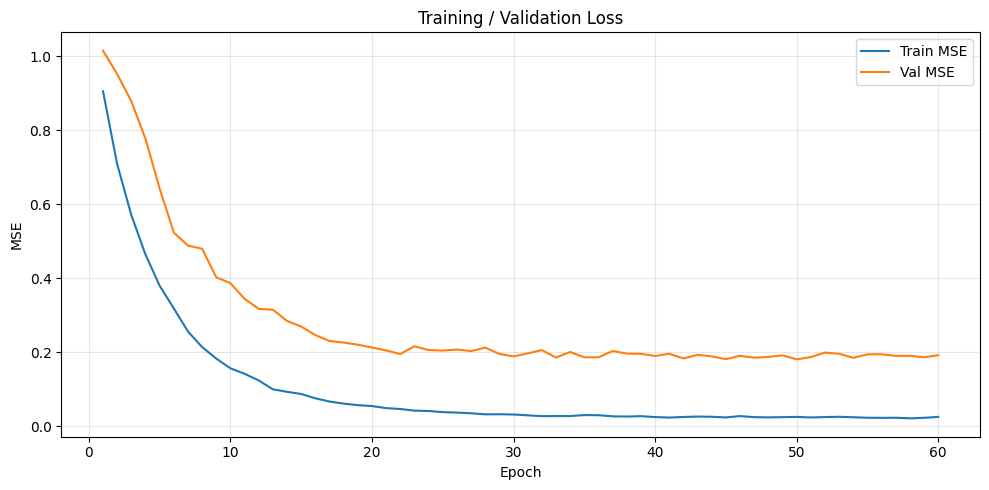


Validation per-patient:
Val — TDL010 -> RMSE 0.4244 | MAE 0.3632 | R2 0.8411 | N=244


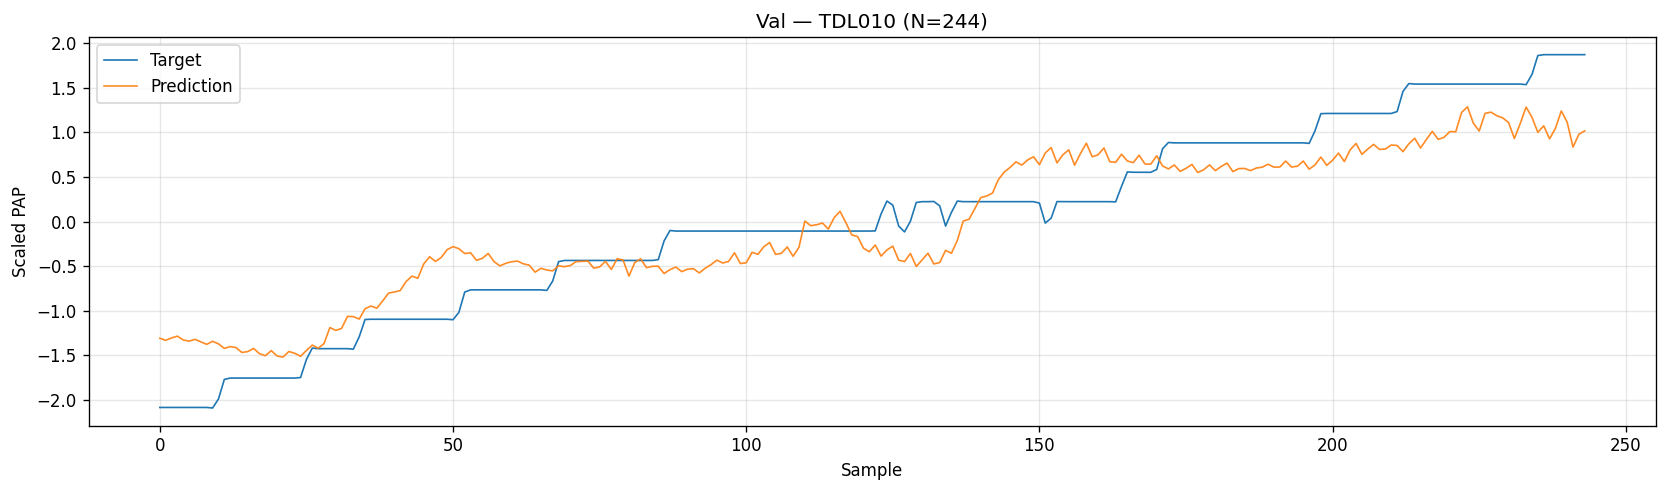

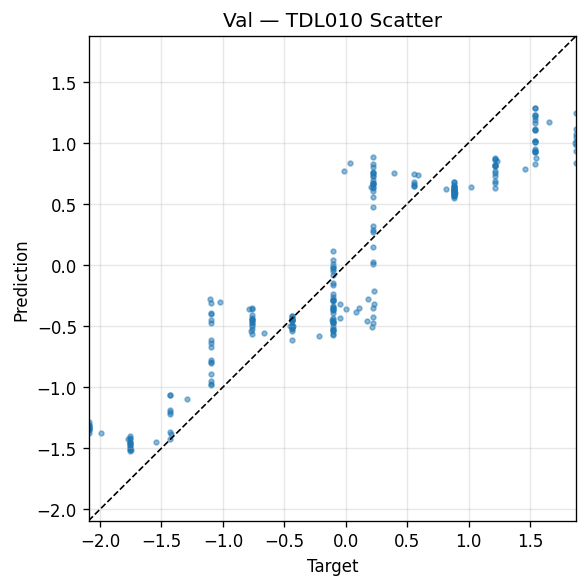


Training per-patient:
Train — TDL013 -> RMSE 0.1253 | MAE 0.0971 | R2 0.9872 | N=244


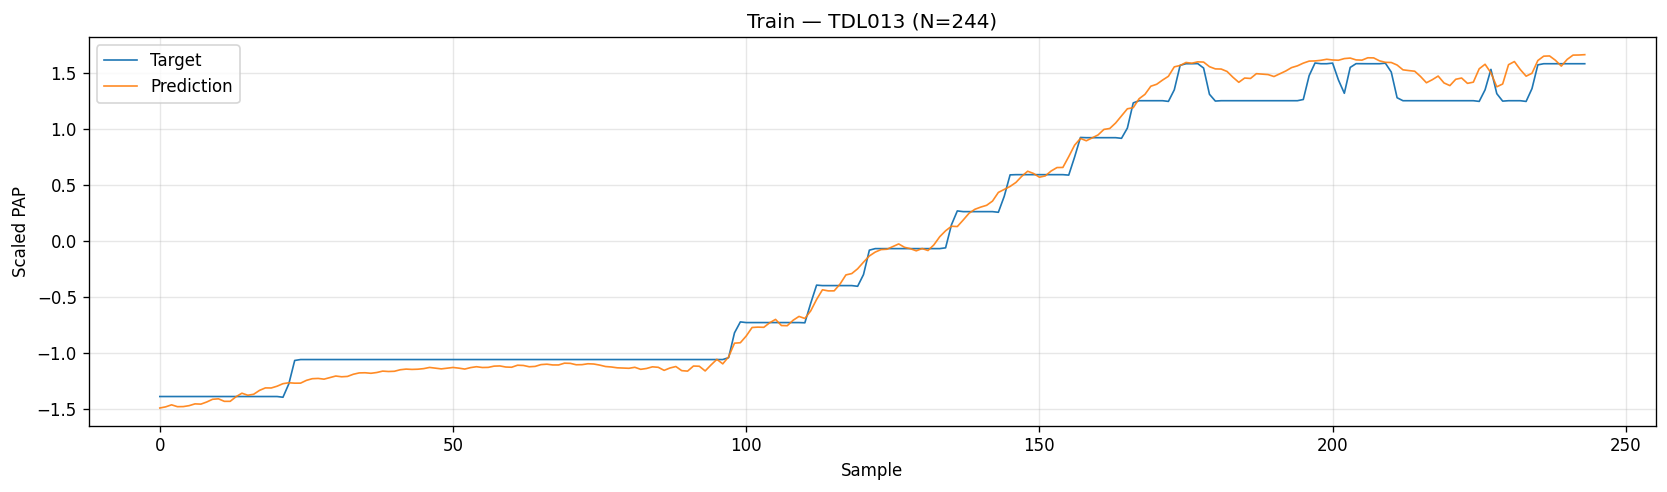

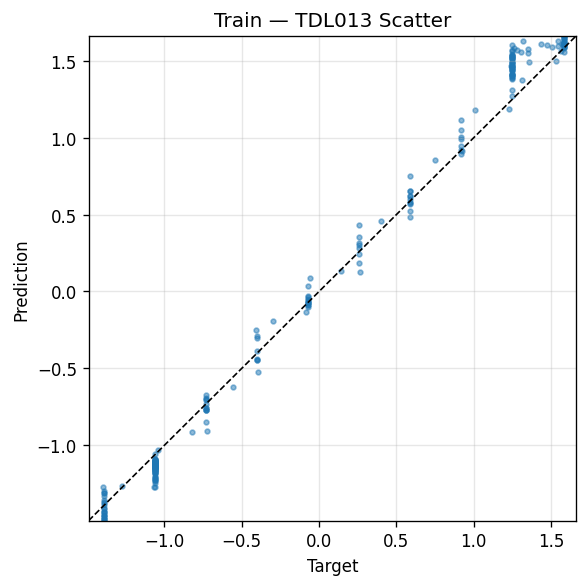

Train — TDL012 -> RMSE 0.0920 | MAE 0.0692 | R2 0.9714 | N=237


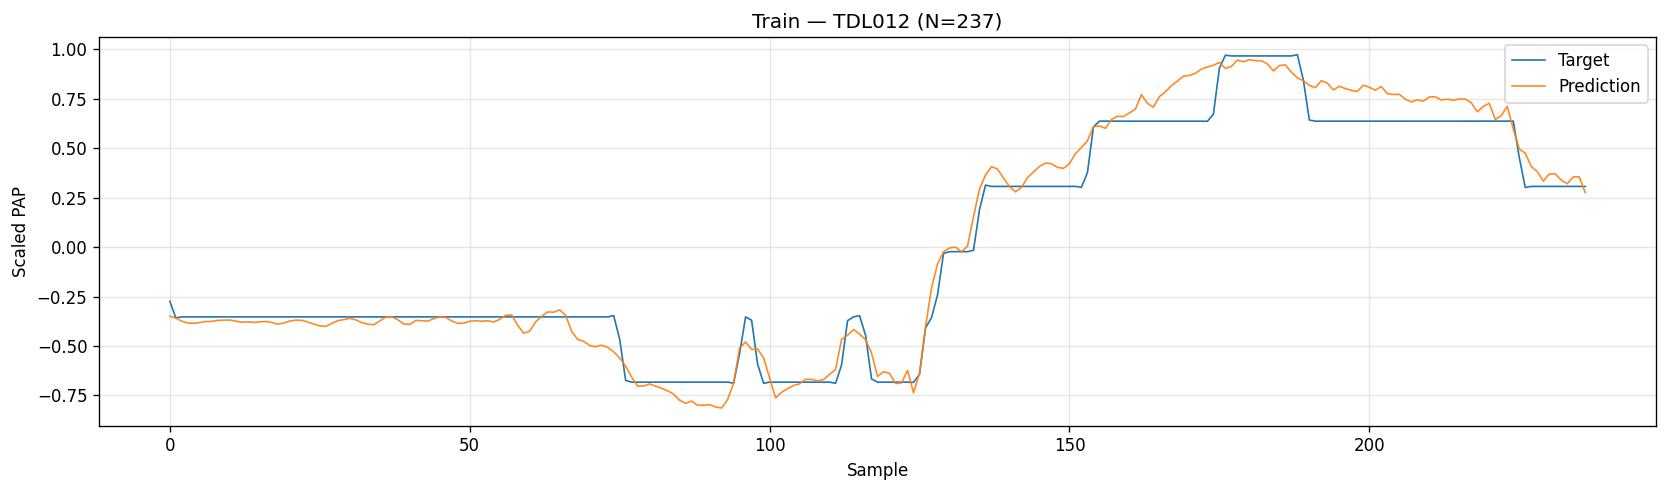

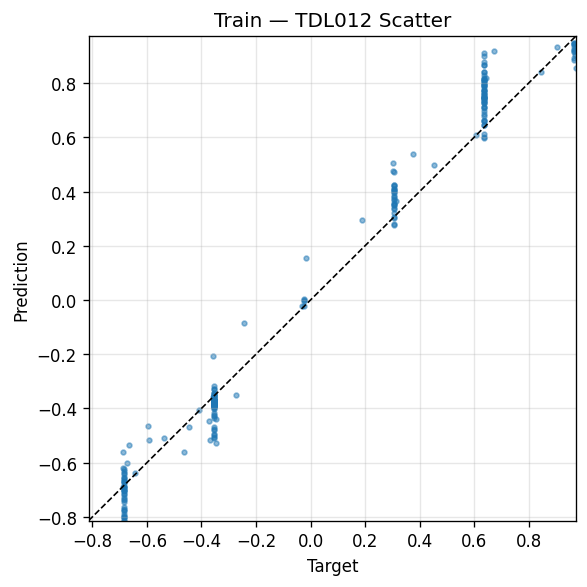

Train — TDL015 -> RMSE 0.0831 | MAE 0.0683 | R2 0.9894 | N=197


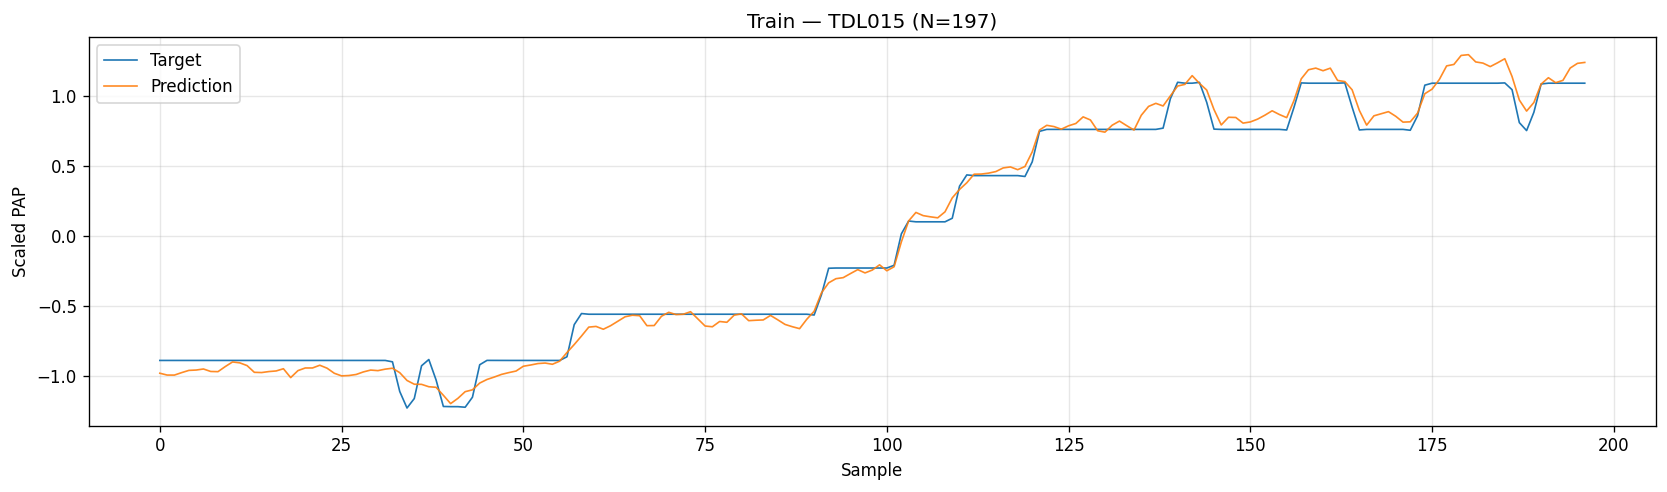

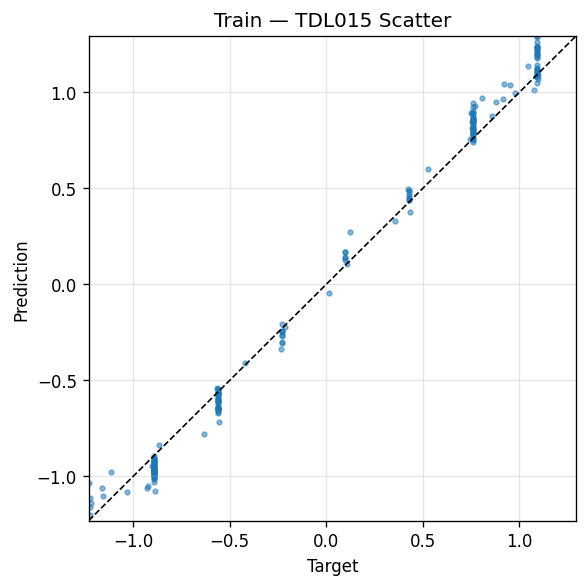

Train — TDL016 -> RMSE 0.1196 | MAE 0.0858 | R2 0.9939 | N=237


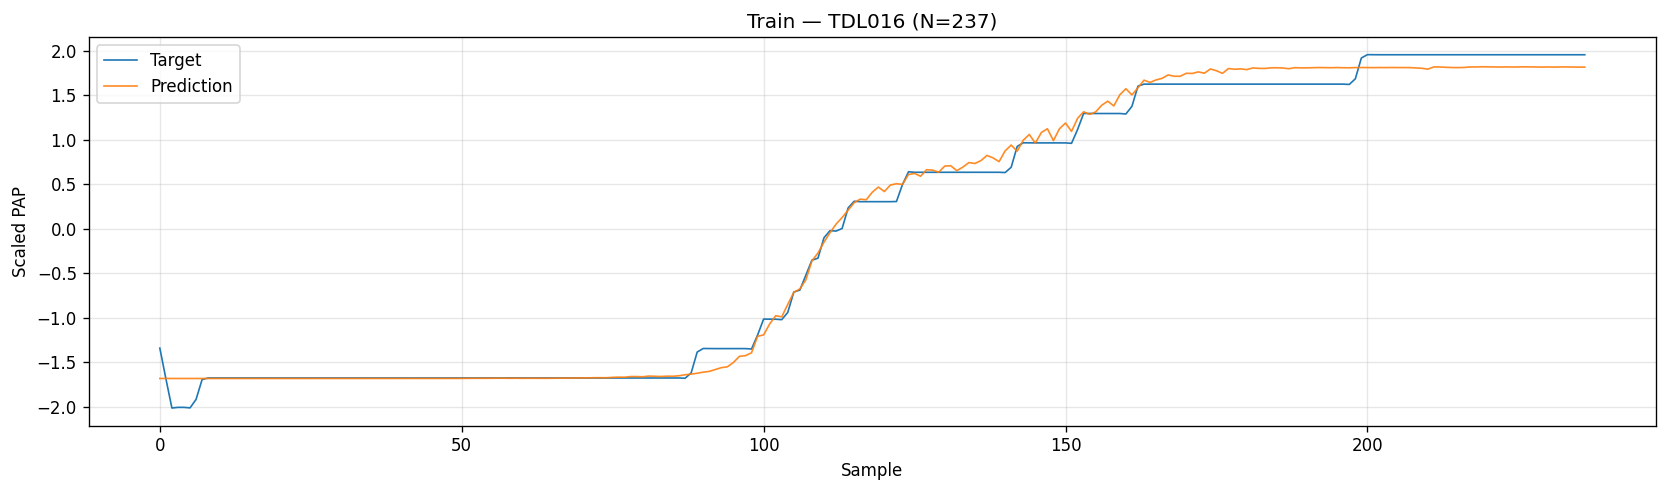

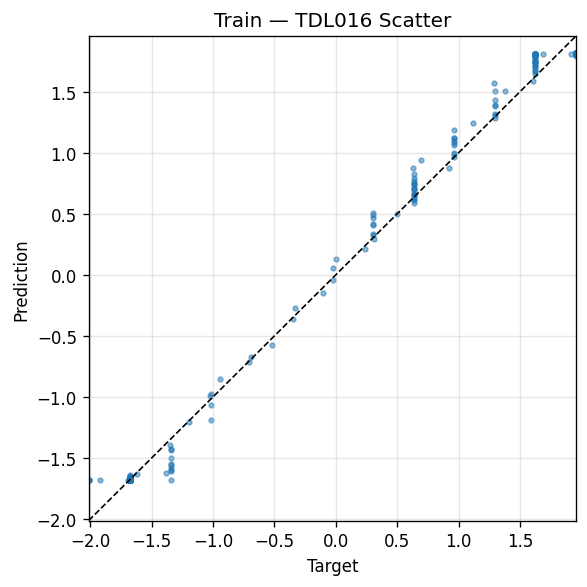

Train — TDL014 -> RMSE 0.0934 | MAE 0.0747 | R2 0.9779 | N=237


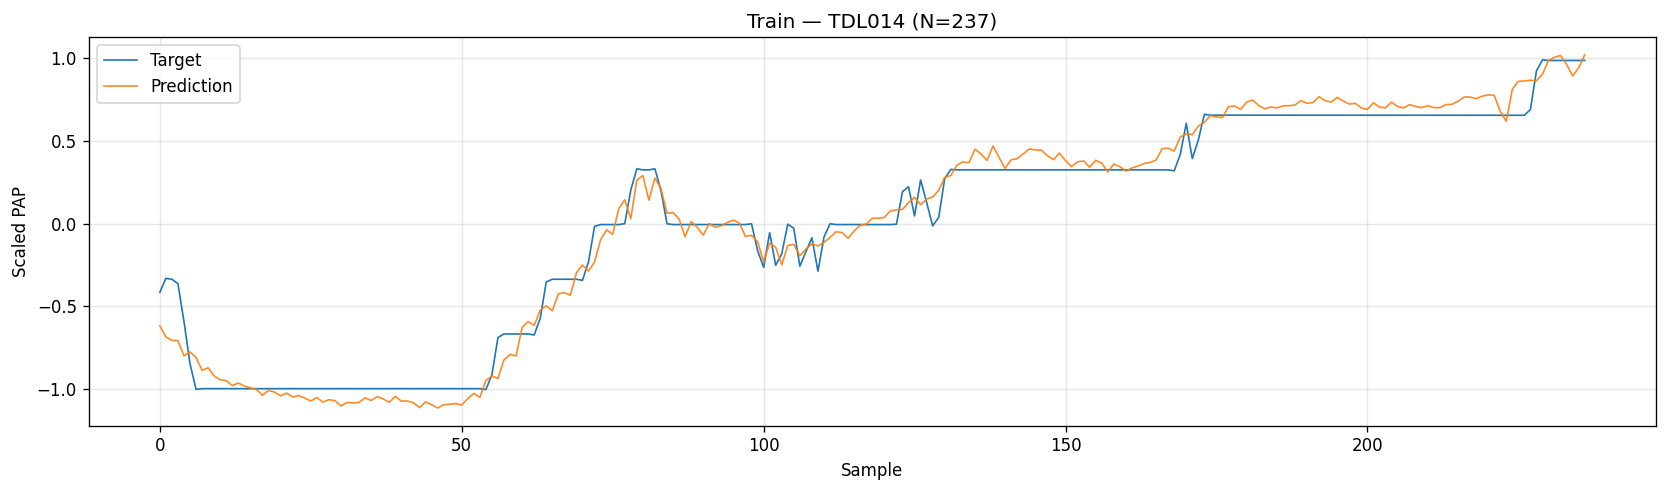

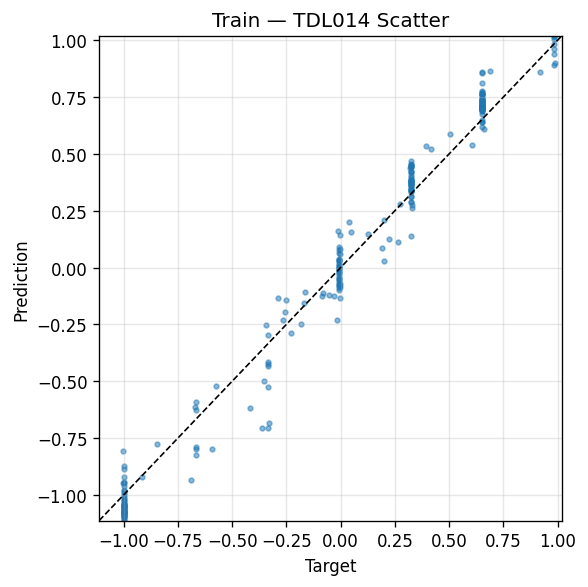


Merged TRAIN -> RMSE 0.1048 | MAE 0.0795 | R2 0.9890 | N=1152
Merged VAL   -> RMSE 0.4244 | MAE 0.3632 | R2 0.8411 | N=244


In [6]:
# 9) Curves & evaluation
plot_curves(train_losses, val_losses)

print("\nValidation per-patient:")
eval_per_patient(model, val_loaders, device=DEVICE, title_prefix="Val — ")

print("\nTraining per-patient:")
eval_per_patient(model, train_loaders, device=DEVICE, title_prefix="Train — ")

# 10) Final merged metrics
_, tr_preds, tr_tgts = epoch_pass(model, train_loader_merged, optimizer=None, device=DEVICE, amp=False)
_, va_preds, va_tgts = epoch_pass(model, val_loader_merged,   optimizer=None, device=DEVICE, amp=False)
tr_m = compute_metrics(tr_preds, tr_tgts)
va_m = compute_metrics(va_preds, va_tgts)
print(f"\nMerged TRAIN -> RMSE {tr_m['rmse']:.4f} | MAE {tr_m['mae']:.4f} | R2 {tr_m['r2']:.4f} | N={tr_m['n']}")
print(f"Merged VAL   -> RMSE {va_m['rmse']:.4f} | MAE {va_m['mae']:.4f} | R2 {va_m['r2']:.4f} | N={va_m['n']}")